In [13]:
import numpy as np # linear algebra
import tensorflow as tf
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [14]:
import glob
gen = [glob.glob('sign_data_ver2/Dataset_Signature_Final/Dataset/dataset1/real/*.*'),
       glob.glob('sign_data_ver2/Dataset_Signature_Final/Dataset/dataset2/real/*.*'),
       glob.glob('sign_data_ver2/Dataset_Signature_Final/Dataset/dataset3/real/*.*'),
       glob.glob('sign_data_ver2/Dataset_Signature_Final/Dataset/dataset4/real1/*.*')]
                 
forg = [glob.glob('sign_data_ver2/Dataset_Signature_Final/Dataset/dataset1/forge/*.*'),
        glob.glob('sign_data_ver2/Dataset_Signature_Final/Dataset/dataset2/forge/*.*'),
        glob.glob('sign_data_ver2/Dataset_Signature_Final/Dataset/dataset3/forge/*.*'),
        glob.glob('sign_data_ver2/Dataset_Signature_Final/Dataset/dataset4/forge/*.*')]

In [15]:
import glob
import keras
import cv2

train_data = []
train_labels = []

test_data = []
test_labels = []

for data in range(len(gen)):
    for i in gen[data]:
        if data == 3:
            image = cv2.imread(i)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            test_data.append(image)
            test_labels.append(0)
        else:
            image = cv2.imread(i)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            train_data.append(image)
            train_labels.append(0) #genuine = 0
        
for data in range(len(forg)):
    for j in forg[data]:
        if data == 3:
            image = cv2.imread(j)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            test_data.append(image)
            test_labels.append(1)
        else:
            image = cv2.imread(j)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            train_data.append(image)
            train_labels.append(1) #forged = 1

train_data = np.array(train_data)/255.0
train_labels = np.array(train_labels)

test_data = np.array(test_data)/255.0
test_labels = np.array(test_labels)

In [16]:
train_data.shape

(540, 224, 224, 3)

In [17]:
from sklearn.utils import shuffle
train_data,train_labels = shuffle(train_data,train_labels)

test_data,test_labels = shuffle(test_data,test_labels)

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, Lambda, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D, Conv2D, BatchNormalization
# from keras.layers.normalization import Normalization
from keras.regularizers import l2
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix as CM
from keras.optimizers import RMSprop, Adam

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet'
                                               )
base_model.trainable = False
                                               
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(1)

network = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

base_learning_rate = 0.001
network.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# network.compile(optimizer=Adam(learning_rate=0.001),loss="binary_crossentropy",metrics=["accuracy"])

In [19]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)

callback_early_stop_reduceLROnPlateau=[earlyStopping]


EPOCHS = 10
BS = 1
progess = network.fit(train_data,train_labels, batch_size=BS,epochs=EPOCHS, callbacks=callback_early_stop_reduceLROnPlateau,validation_split=.05)

Epoch 1/10
513/513 [==============================] - 24s 40ms/step - loss: 0.6775 - accuracy: 0.6101 - val_loss: 0.8806 - val_accuracy: 0.5185
Epoch 2/10
513/513 [==============================] - 19s 37ms/step - loss: 0.5023 - accuracy: 0.7544 - val_loss: 0.6200 - val_accuracy: 0.6667
Epoch 3/10
513/513 [==============================] - 19s 38ms/step - loss: 0.4047 - accuracy: 0.8090 - val_loss: 0.5265 - val_accuracy: 0.7037
Epoch 4/10
513/513 [==============================] - 19s 38ms/step - loss: 0.3381 - accuracy: 0.8519 - val_loss: 0.5754 - val_accuracy: 0.7778
Epoch 5/10
513/513 [==============================] - 19s 38ms/step - loss: 0.2983 - accuracy: 0.8616 - val_loss: 0.5524 - val_accuracy: 0.7778
Epoch 6/10
513/513 [==============================] - 19s 37ms/step - loss: 0.2678 - accuracy: 0.8908 - val_loss: 0.5852 - val_accuracy: 0.7037
Epoch 6: early stopping


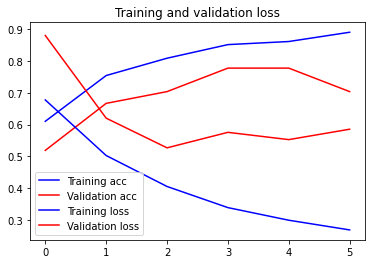

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [20]:
acc = progess.history['accuracy']
val_acc = progess.history['val_accuracy']
loss = progess.history['loss']
val_loss = progess.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()
 
plt.figure()

In [21]:
pred = network.predict(test_data)
pred

6/6 [==============================] - 5s 645ms/step


array([[ 6.23415   ],
       [ 4.652148  ],
       [-2.4823413 ],
       [ 2.7408078 ],
       [ 0.35168767],
       [-1.9056566 ],
       [ 1.6363336 ],
       [ 2.0846345 ],
       [-1.3310854 ],
       [-3.983819  ],
       [-3.3803496 ],
       [ 1.1278561 ],
       [-1.3411703 ],
       [ 3.973161  ],
       [ 3.9954305 ],
       [-0.7762189 ],
       [ 4.03007   ],
       [-0.6960177 ],
       [ 2.2857263 ],
       [ 2.2981057 ],
       [ 3.7213297 ],
       [ 1.1292546 ],
       [ 0.9167528 ],
       [-2.7713401 ],
       [ 3.0007634 ],
       [-3.9819987 ],
       [ 4.245469  ],
       [ 3.895941  ],
       [ 1.2939072 ],
       [-0.6425125 ],
       [-1.6965244 ],
       [-5.0419793 ],
       [ 0.72276   ],
       [ 4.3711486 ],
       [ 4.0351915 ],
       [ 2.6412218 ],
       [-1.0525429 ],
       [ 4.462638  ],
       [-6.4967413 ],
       [ 1.0807452 ],
       [ 1.495597  ],
       [ 2.4981802 ],
       [ 0.45266247],
       [-3.9467158 ],
       [ 0.18835329],
       [-4

In [22]:
test_loss, test_acc = network.evaluate(test_data, test_labels, verbose=1) 
print("Test Accuracy:", test_acc)

6/6 [==============================] - 5s 645ms/step - loss: 0.7979 - accuracy: 0.6944
Test Accuracy: 0.6944444179534912


In [23]:
network.save("ver2_mobilenetv2.h5")